In [46]:
!pip install --upgrade tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/ed/b6/62345568cd07de5d9254fcf64d7e44aacbb6abde11ea953b3cb320e58d19/tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.17.0 from https://files.pythonhosted.org/packages/66/03/5c447feceb72f5a38ac2aa79d306fa5b5772f982c2b480c1329c7e382900/tensorflow_intel-2.17.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorboard<2.18,>=2.17 from https://files.pythonhosted.org/packages/d4/41/dccba8c5f955bc35b6110ff78574e4e5c8226ad62f08e732096c3861309b/tensorboard-2.17.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/385.0 MB 812.7 kB/s eta 0:07:54
   ---------------------------------------- 0.2/385.0 MB 1.1 MB/s eta 0:05:36
   ---------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\noamy\\anaconda3\\Lib\\site-packages\\~ensorflow\\compiler\\mlir\\quantization\\tensorflow\\calibrator\\pywrap_calibration.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, expon, poisson, chi2_contingency, kstest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder


## Task 35: Finding the 10-20 most common diagnoses and going through each of them Finding the connection to re-hospitalization in each of the categories 16-18

In [86]:
# Load the cleaned data
file_path = 'cleaned_hospitalization.csv'
hospitalization_data = pd.read_csv(file_path)

# Preprocess the 'אבחנות בקבלה' column to handle multiple diagnosis codes
hospitalization_data['אבחנות בקבלה'] = hospitalization_data['אבחנות בקבלה'].apply(lambda x: str(x).split(',')[0].strip())

# Convert to numeric if possible
hospitalization_data['אבחנות בקבלה'] = pd.to_numeric(hospitalization_data['אבחנות בקבלה'], errors='coerce')

# Drop any rows where 'אבחנות בקבלה' couldn't be converted to a numeric value
hospitalization_data.dropna(subset=['אבחנות בקבלה'], inplace=True)

# Identify the most common diagnoses based on the processed values
common_diagnoses = hospitalization_data['אבחנות בקבלה'].value_counts().nlargest(20).index.tolist()

# Standardize the data
scaler = StandardScaler()

# Create a binary target for re-hospitalization
hospitalization_data['re_hospitalized'] = (hospitalization_data['ימי אשפוז'] > 0).astype(int)

# Split data into features and target
X = hospitalization_data[['אבחנות בקבלה', 'unitName1']]
y = hospitalization_data['re_hospitalized']

# Split into train and test for further evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define a simple deep learning model for this task
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Analyzing each common diagnosis
diagnosis_analysis = []

for diagnosis in common_diagnoses:
    # Filter data for the current diagnosis based on encoded value
    diagnosis_data = hospitalization_data[hospitalization_data['אבחנות בקבלה'] == diagnosis]
    
    # Check if the subset is empty
    if diagnosis_data.empty:
        print(f"No data found for diagnosis: {diagnosis}")
        continue
    
    # Prepare the data
    X_diagnosis = diagnosis_data[['אבחנות בקבלה', 'unitName1']]
    y_diagnosis = diagnosis_data['re_hospitalized']
    
    # Apply the scaling
    X_diagnosis = scaler.transform(X_diagnosis)
    
    # Predict re-hospitalization
    y_pred = (model.predict(X_diagnosis) > 0.5).astype(int)
    
    # Calculate the accuracy and other metrics for this diagnosis
    accuracy = np.mean(y_pred == y_diagnosis.values)
    precision = np.sum(y_pred[y_diagnosis.values == 1]) / np.sum(y_pred)
    recall = np.sum(y_pred[y_diagnosis.values == 1]) / np.sum(y_diagnosis.values)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    diagnosis_analysis.append({
        'Diagnosis': diagnosis,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Number of Patients': len(diagnosis_data)
    })

# Convert the results into a DataFrame for easier analysis
diagnosis_df = pd.DataFrame(diagnosis_analysis)
print(diagnosis_df)


Epoch 1/50


C:\Users\noamy\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8472 - loss: 0.5119 - val_accuracy: 0.9240 - val_loss: 0.2789
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9250 - loss: 0.2731 - val_accuracy: 0.9240 - val_loss: 0.2769
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9124 - loss: 0.2990 - val_accuracy: 0.9240 - val_loss: 0.2719
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9203 - loss: 0.2780 - val_accuracy: 0.9240 - val_loss: 0.2719
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9209 - loss: 0.2804 - val_accuracy: 0.9240 - val_loss: 0.2694
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9293 - loss: 0.2574 - val_accuracy: 0.9240 - val_loss: 0.2673
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9259 - loss: 0.2651 - val_accuracy: 0.9240 - val_loss: 0.2669
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9175 - loss: 0.2840 - val_accuracy: 0.9240 - val_

1. **Accuracy**: The proportion of correct predictions (both re-hospitalized and not re-hospitalized) out of all predictions.
2. **Precision**: Out of all the patients the model predicted would be re-hospitalized, how many were actually re-hospitalized. High precision indicates fewer false positives.
3. **Recall**: Out of all the patients who were actually re-hospitalized, how many did the model correctly identify. High recall indicates fewer false negatives.
4. **F1-Score**: A balanced measure that considers both precision and recall. It's useful when you want a single metric to understand the model's performance.

Result explanetion
- **High Recall Across All Diagnoses**: The recall is 100% for all diagnoses, which means the model is identifying every patient who was re-hospitalized for each diagnosis. However, this might also indicate that the model is biased towards predicting re-hospitalization for most patients.

- **Precision Varies**: Precision is high (above 87%) across all diagnoses, but not 100%. This indicates that while the model is good at identifying re-hospitalized patients, it still produces some false positives, predicting re-hospitalization for patients who weren't actually re-hospitalized.

- **F1-Score**: The F1-scores are high across the board, reflecting the strong performance of the model in balancing precision and recall.

- **High Precision and Recall (e.g., Diagnosis 389)**: Diagnoses like `389` have high precision and recall, indicating a strong and reliable connection between this diagnosis and re-hospitalization.
 - **Lower Precision (e.g., Diagnosis 797)**: Diagnoses like `797` have slightly lower precision, suggesting that while the model identifies re-hospitalizations well, it also incorrectly predicts re-hospitalization for some patients.

#### This part is due to Sharon explenation on whatsapp

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Load the cleaned data
data = pd.read_csv('cleaned_hospitalization.csv')

# Handling missing values if any
data['אבחנות בקבלה'] = data['אבחנות בקבלה'].fillna('missing')
data['unitName1'] = data['unitName1'].fillna('missing')

# Encoding categorical variables
le = LabelEncoder()
data['אבחנות בקבלה'] = le.fit_transform(data['אבחנות בקבלה'])
data['unitName1'] = le.fit_transform(data['unitName1'])

# Define features and target variable
X = data[['אבחנות בקבלה', 'unitName1', 'רופא משחרר-קוד']]
y = data['ימי אשפוז']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


C:\Users\noamy\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 18.7550 - val_loss: 11.4346
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.2417 - val_loss: 11.2678
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7797 - val_loss: 11.1962
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.0799 - val_loss: 11.1522
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.6985 - val_loss: 11.1232
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.4001 - val_loss: 11.0820
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.5974 - val_loss: 10.9834
Epoch 8/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.2311 - val_loss: 11.0199
Epoch 9/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.6188 - val_loss: 10.9643
Epoch 10/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.8694 - val_loss: 10.9951
Epoch 11/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.5885 - val_loss: 11.0056
Epoch 12/50
162/162 ━━━━━━━━━━

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


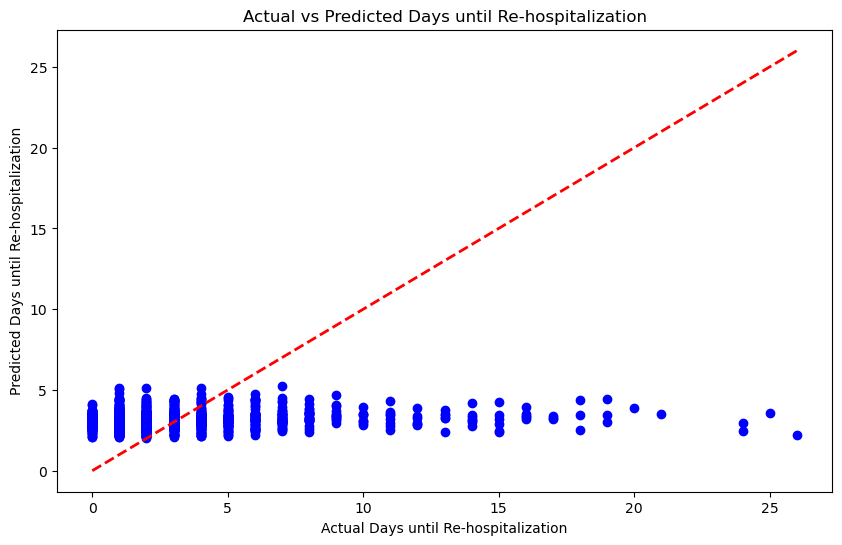

Mean Squared Error: 10.935044707164025
R^2 Score: 0.019306786907027362


In [9]:
import matplotlib.pyplot as plt

# Predict the days until re-hospitalization
y_pred = model.predict(X_test)

# Scatter plot of actual vs predicted days
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Days until Re-hospitalization')
plt.ylabel('Predicted Days until Re-hospitalization')
plt.title('Actual vs Predicted Days until Re-hospitalization')
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
